In [ ]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
%cd "ctorch220301/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220118/MiniCTorch_Prototype/notebook


In [ ]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from tqdm import tqdm, trange

In [ ]:
DEVICE = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
BATCH_SIZE = 4
TEST_BATCH_SIZE = 5

"""
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fmnist', train=True, download=True,
    transform=transforms.ToTensor()), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fmnist', train=False, download=True,
    transform=transforms.ToTensor()), batch_size=TEST_BATCH_SIZE, shuffle=False)
"""

fashion_mnist_train = datasets.FashionMNIST('./fmnist', train=True,  download=True,transform=transforms.ToTensor())
fashion_mnist_test  = datasets.FashionMNIST('./fmnist', train=False, download=True,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader( fashion_mnist_train, batch_size=BATCH_SIZE, shuffle=True )
test_loader  = torch.utils.data.DataLoader( fashion_mnist_test , batch_size=BATCH_SIZE, shuffle=True )

TRAIN_SIZE  = len(train_loader.dataset)
TEST_SIZE   = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 1
SAMPLES = 2
TEST_SAMPLES = 10


In [ ]:
print("train_size",TRAIN_SIZE)
print("test_size",TEST_SIZE)
print("num_batches",NUM_BATCHES)
print("num_test_batches",NUM_TEST_BATCHES)
print("fashion_mnist_train", len(fashion_mnist_train))
print("fashion_mnist_test" , len(fashion_mnist_test))
fashion_mnist_test


train_size 60000
test_size 10000
num_batches 15000
num_test_batches 2500
fashion_mnist_train 60000
fashion_mnist_test 10000


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./fmnist
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (- math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [ ]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [ ]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        PI = 0.5
        SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(DEVICE)
        SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(DEVICE)
        self.weight_p = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_p   = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_p = 0
        self.log_q = 0

    def forward(self, input, sample=False,):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        self.log_p = self.weight_p.log_prob(weight) + self.bias_p.log_prob(bias)
        self.log_q = self.weight.log_prob(weight)   + self.bias.log_prob(bias)
        return F.linear(input, weight, bias)
    

In [ ]:
SAMPLES = 3
DEVICE  = 'cpu'
class BBBLoss(nn.Module):
  def __init__(self, samples=SAMPLES):
    super().__init__()
    self.samples=samples

  def forward(self, x, target, model):
    #print("loss forward")
    #print("x",x)
    #print("target",target)
    outputs, log_ps, log_qs = model.sample(x,samples=self.samples)
    #print("outputs",outputs)
    #print("log_ps",log_ps)
    #print("log_qs",log_qs)
    log_p = log_ps.mean()
    log_q = log_qs.mean()
    #print("log_ps2",log_ps)
    #print("log_qs2",log_qs)
    nll = F.nll_loss(outputs.mean(0), target, size_average=False)
    loss = (log_q - log_p)/NUM_BATCHES + nll
    return loss
    
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    """ #220107 mod
    def sample(self, x, samples=SAMPLES):
      outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
      log_ps = torch.zeros(samples).to(DEVICE)
      log_qs = torch.zeros(samples).to(DEVICE)
      for i in range(samples):
          outputs[i] = self(x, sample=True)
          log_ps[i] = self.log_p()
          log_qs[i] = self.log_q()
      return outputs, log_ps, log_qs
    """
    def sample(self, x, samples=SAMPLES):
      outputs = [] #torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
      log_ps  = [] #torch.zeros(samples).to(DEVICE)
      log_qs  = [] #torch.zeros(samples).to(DEVICE)
      for i in range(samples):
          outputs.append(self(x, sample=True))
          log_ps.append(self.log_p())
          log_qs.append(self.log_q())
      outputs = torch.stack(outputs)
      log_ps  = torch.stack(log_ps)
      log_qs  = torch.stack(log_qs)
      return outputs, log_ps, log_qs
    
    def log_p(self):
        return self.l1.log_p + self.l2.log_p + self.l3.log_p
    
    def log_q(self):
        return self.l1.log_q + self.l2.log_q + self.l3.log_q
    

class Net(nn.Module):
  def __init__(self, target, samples=SAMPLES):
    super().__init__()
    self.samples=samples
    self.net = BayesianNetwork()
    self.net.train()
    self.loss_func = BBBLoss()
    self.target=target
    print("samples",samples)
    print("target",target)

  def forward(self, x):
    loss = self.loss_func(x, self.target, self.net)
    return loss


In [ ]:
#learning loop
model=Net(None)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters())

for epoch in range(TRAIN_EPOCHS):
  sum_loss=0
  sum_count=0
  for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    data, target = data.to(DEVICE), target.to(DEVICE)
    model.zero_grad()
    model.target=target
    loss = model(data)
    loss.backward()
    optimizer.step()
    sum_loss+=loss.item()
    sum_count+=1
  avg_loss=sum_loss/sum_count
  print(avg_loss)

In [ ]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 6.8 MB/s 


In [ ]:
#import minctorch
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

In [ ]:
project = 'bbb3'
folder = './bbb'
json_path = folder + '/' + project +'.json'

In [ ]:
! mkdir -p bbb

In [ ]:
! jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-notebook", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-7>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    return method(app, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/notebook/notebookapp.py", line 1368, in initialize
    self.init_webapp()
  File "/usr/local/lib/python2.7/dist-packages/notebook/notebookapp.py", line 1188, in init_webapp
    self.http_server.listen(port, self.ip)
  File "/usr/local/lib/python2.7/dist-packages/torna

In [ ]:
def generate_json( json_path, x,y ):
  with torch.no_grad():
    model=Net(y)
    print("[SAVE]", json_path )
    minictorch.trace( model, x, json_path )
  return model

In [ ]:
import minictorch

torch.manual_seed( 1 )
for data, target in train_loader:
  x=data
  y=target
  break

model = generate_json( json_path, x, y )

In [ ]:
print("x shape", x.shape)
print("y shape", y.shape)

x shape torch.Size([4, 1, 28, 28])
y shape torch.Size([4])


In [ ]:
train_loader2 = torch.utils.data.DataLoader( fashion_mnist_train, batch_size=40, shuffle=True )
for data, target in train_loader2:
  x2=data
  y2=target
  break
print("x2 shape",x2.shape)
print("y2 shape",y2.shape)

x2 shape torch.Size([40, 1, 28, 28])
y2 shape torch.Size([40])


In [ ]:
minictorch.convert_all(project, folder, model, json_path, x,{"input_data":x2, "target_data":y2}, code="all", sol="bayesian", epochs=10, batch=4, shuffle=0, seed=1, shape=1 )

In [ ]:
C_SRC = './bbb/bbb3.cpp ./bbb/bbb3_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './bbb/bbb3'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./bbb/bbb3.cpp ./bbb/bbb3_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./bbb/bbb3


In [ ]:
# check shape
! ./bbb/bbb3

In [ ]:
# check code
model.train()
z = model( x )
print(z)
z.sum().backward()
print(x.grad)

tensor(143.8900, grad_fn=<AddBackward0>)
None


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# loop test
model.train()
epoch_num = 10
z = model( x )
print(z)
lr = 0.01
#optimizer = optim.Adam(model.parameters())
optimizer = optim.SGD(model.parameters(),lr)

sum_loss=0
for epoch in range(epoch_num):
    model.zero_grad()
    #model.target=y
    loss = model(x)
    loss.backward()
    optimizer.step()
    sum_loss+=loss.item()
    print("epoch :",epoch,"  loss", loss.item())
print("sum loss",sum_loss)

In [ ]:
C_SRC = './bbb/bbb_train.cpp ./bbb/bbb_data.cpp ./bbb/bbb_param.cpp ./bbb/bbb.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './bbb/bbb_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -D_TRAIN -lcblas -o $C_OUT

SRC = ./bbb/bbb2_train.cpp ./bbb/bbb2_data.cpp ./bbb/bbb2_param.cpp ./bbb/bbb2.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./bbb/bbb2_train


In [ ]:
! ./bbb/bbb_train

In [ ]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

epoch_loss = []

datalist = f.readlines()
for data in datalist:
  #print(data)
  epoch_loss.append( float(data) )

f.close()

print("[out]",path)
print("epoch =", len(epoch_loss))
print( epoch_loss)

[out] ./bbb/bbb2.out
epoch = 10
[253.650513, 179.875244, 178.233704, 154.890167, 150.285202, 149.028366, 147.696045, 148.076721, 145.737717, 144.097443]


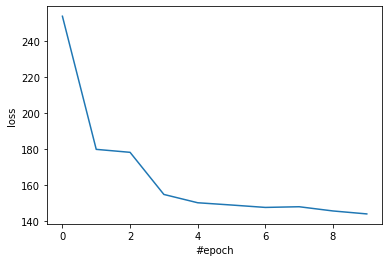

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()